## Problem Definition

This project tries to classify people as extroverts or introverts depending on what they do on a daily basis. The information provided has qualities such as how much time a person spends by themselves, how often they attend social events, how often they go out, and how exhausted they are after socialization. These activities are mostly common with personality traits and can help us establish trends which distinguish extroverts from introverts.

The final goal is to develop a machine learning system that uses these cues of behavior to make reliable decisions about a person's personality type. This could be used in real-world applications such as mental health treatment, personalizing content, education, and recruitment—where knowing something about a person's personality type can assist in better user experiences and decision-making.

The task is to manage individual differences and behaviors that overlap, while maintaining good generalization to new, unseen individuals.



## About the Dataset

The dataset comes from Kaggle and is titled **"Extrovert vs Introvert Behavior Data"**. It contains self-reported data from individuals, covering a variety of behavioral features such as:

* **Time\_spent\_Alone** – Number of hours spent alone daily
* **Stage\_fear** – Whether the person has stage fear (Yes/No)
* **Social\_event\_attendance** – Frequency of attending social events
* **Going\_outside** – Frequency of going outside per week
* **Drained\_after\_socializing** – Whether the person feels drained after socializing (Yes/No)
* **Friends\_circle\_size** – Estimated number of close friends
* **Post\_frequency** – Frequency of posting on social media
* **Personality** – Target label: Introvert or Extrovert





#### Main tools

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, make_scorer
)


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import optuna


## Expoloratory Data Analysis

In [2]:
df = pd.read_csv('/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv')

In [3]:
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert
...,...,...,...,...,...,...,...,...
2895,3.0,No,7.0,6.0,No,6.0,6.0,Extrovert
2896,3.0,No,8.0,3.0,No,14.0,9.0,Extrovert
2897,4.0,Yes,1.0,1.0,Yes,4.0,0.0,Introvert
2898,11.0,Yes,1.0,NaN,Yes,2.0,0.0,Introvert


In [4]:
# Set visual style
sns.set(style="whitegrid")

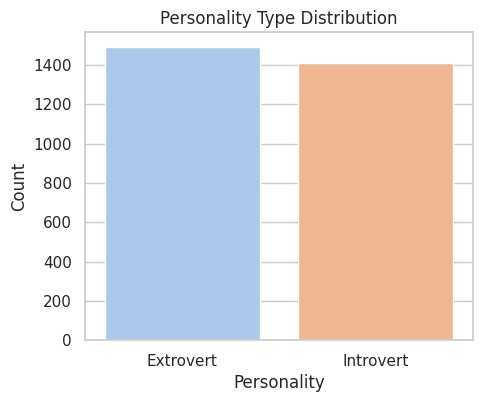

In [5]:
plt.figure(figsize=(5, 4))
sns.countplot(x="Personality", data=df, palette="pastel")
plt.title("Personality Type Distribution")
plt.xlabel("Personality")
plt.ylabel("Count")
plt.show()

The dataset is semi balanced, So using SMOTE to balance the dataset is not a necessity.

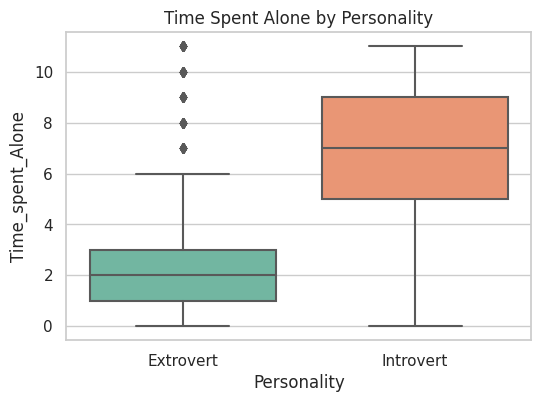

In [6]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Personality", y="Time_spent_Alone", data=df, palette="Set2")
plt.title("Time Spent Alone by Personality")
plt.show()

The introvert lean more to spend more time alone.

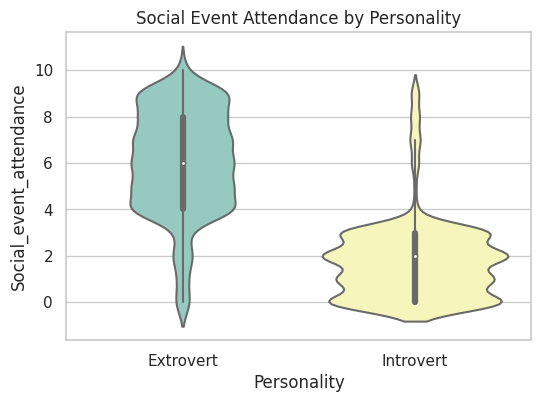

In [7]:
plt.figure(figsize=(6, 4))
sns.violinplot(x="Personality", y="Social_event_attendance", data=df, palette="Set3")
plt.title("Social Event Attendance by Personality")
plt.show()

The introvert tend to have less social attendence.

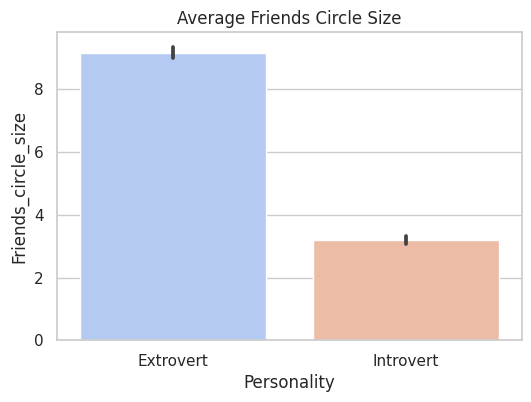

In [8]:
plt.figure(figsize=(6, 4))
sns.barplot(x="Personality", y="Friends_circle_size", data=df, palette="coolwarm", estimator='mean')
plt.title("Average Friends Circle Size")
plt.show()

The Introvert attends to have less friends.

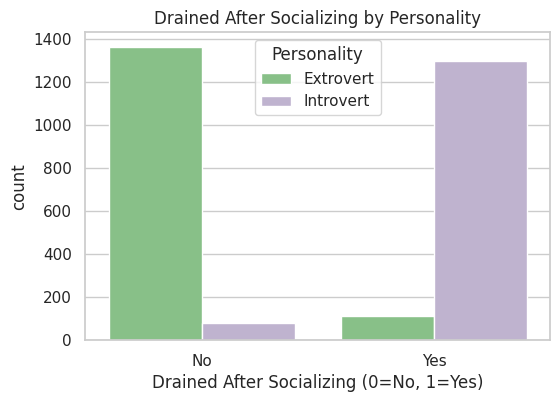

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Drained_after_socializing", hue="Personality", data=df, palette="Accent")
plt.title("Drained After Socializing by Personality")
plt.xlabel("Drained After Socializing (0=No, 1=Yes)")
plt.show()


## Data Preprocessing

In [10]:
df['Stage_fear'] = df['Stage_fear'].map({'Yes': 1, 'No': 0})
df['Drained_after_socializing'] = df['Drained_after_socializing'].map({'Yes': 1, 'No': 0})
df['Personality'] = df['Personality'].map({'Extrovert':0, 'Introvert':1})

Convert str features to int features.

In [11]:
df.isna().sum()

Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64

In [12]:
# Imputation strategies
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

In [13]:
df[['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Post_frequency']] = \
    mean_imputer.fit_transform(df[['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Post_frequency']])

df[['Friends_circle_size']] = median_imputer.fit_transform(df[['Friends_circle_size']])

df[['Stage_fear', 'Drained_after_socializing']] = \
    mode_imputer.fit_transform(df[['Stage_fear', 'Drained_after_socializing']])


In [14]:
df.isna().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

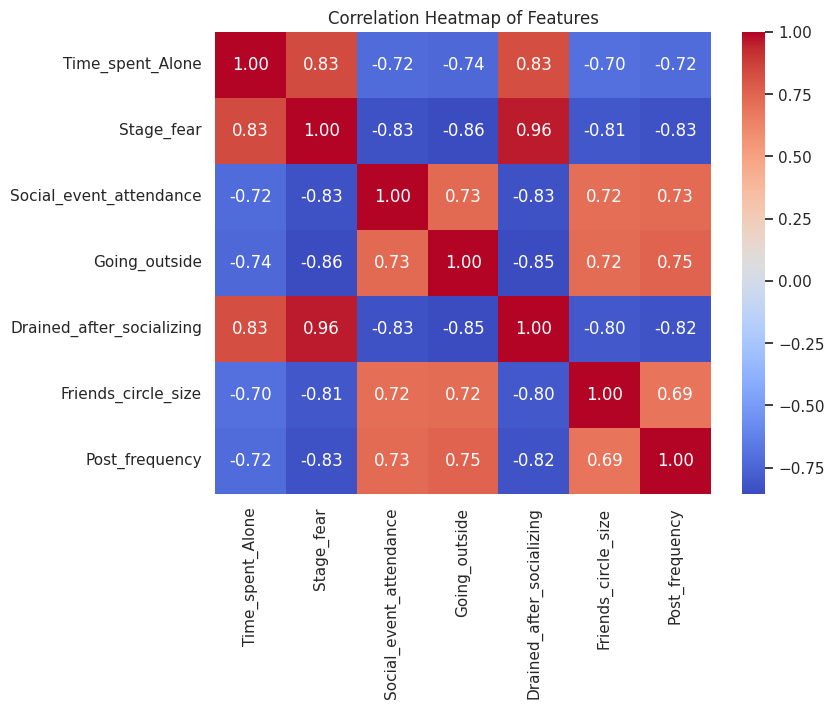

In [15]:
plt.figure(figsize=(8, 6))
numeric_df = df.drop(columns=["Personality"])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

There is a high correlation between Drain_after_socializing and Stage_fear, so dropping one of them would make the model performance better.

In [16]:
df = df.drop(['Drained_after_socializing'], axis=1)

In [17]:
df

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Personality
0,4.0,0.0,4.0,6.0,13.0,5.0,0
1,9.0,1.0,0.0,0.0,0.0,3.0,1
2,9.0,1.0,1.0,2.0,5.0,2.0,1
3,0.0,0.0,6.0,7.0,14.0,8.0,0
4,3.0,0.0,9.0,4.0,8.0,5.0,0
...,...,...,...,...,...,...,...
2895,3.0,0.0,7.0,6.0,6.0,6.0,0
2896,3.0,0.0,8.0,3.0,14.0,9.0,0
2897,4.0,1.0,1.0,1.0,4.0,0.0,1
2898,11.0,1.0,1.0,3.0,2.0,0.0,1


In [18]:
X = df.drop(columns=['Personality'])
y = df['Personality']

In [19]:
print("Scaled Feature Set Sample:")
print(X.head())
print('---------------------------------------')
print("Encoded Target Sample:")
print(y.head())


Scaled Feature Set Sample:
   Time_spent_Alone  Stage_fear  Social_event_attendance  Going_outside  \
0               4.0         0.0                      4.0            6.0   
1               9.0         1.0                      0.0            0.0   
2               9.0         1.0                      1.0            2.0   
3               0.0         0.0                      6.0            7.0   
4               3.0         0.0                      9.0            4.0   

   Friends_circle_size  Post_frequency  
0                 13.0             5.0  
1                  0.0             3.0  
2                  5.0             2.0  
3                 14.0             8.0  
4                  8.0             5.0  
---------------------------------------
Encoded Target Sample:
0    0
1    1
2    1
3    0
4    0
Name: Personality, dtype: int64


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Choose A Model

We will compare more than one model, after that we will choose the best model, then we will run optuna to get the best hyperparatmers for the best model.

In [21]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost (default)": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "XGBoost (tuned)": XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1,
                                      use_label_encoder=False, eval_metric='logloss')
}


In [22]:
# Train and evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1-score': f1
    })


results_df = pd.DataFrame(results).sort_values(by='F1-score', ascending=False)
print("📊 Model Comparison (Single Train/Test Split):")
print(results_df)


📊 Model Comparison (Single Train/Test Split):
                    Model  Accuracy  F1-score
3  Support Vector Machine  0.929310  0.927176
6         XGBoost (tuned)  0.929310  0.927176
2     K-Nearest Neighbors  0.925862  0.923623
1           Random Forest  0.924138  0.921708
0     Logistic Regression  0.924138  0.921429
5       XGBoost (default)  0.918966  0.916814
4           Decision Tree  0.875862  0.872340


As shown in the table, the SVMs model gives the best performance.

## Hyperparamter Fine-tuning

In [23]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])

    clf = SVC(C=C, gamma=gamma, kernel=kernel)

    score = cross_val_score(clf, X_train, y_train, cv=5,
                            scoring=make_scorer(f1_score)).mean()
    time.sleep(2)
    return score


In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-06-29 12:03:00,216] A new study created in memory with name: no-name-a3398087-6088-49f2-96bd-a05ba4e9925f
/tmp/ipykernel_35/2161705337.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
/tmp/ipykernel_35/2161705337.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1)
[I 2025-06-29 12:03:03,443] Trial 0 finished with value: 0.1052027004775817 and parameters: {'C': 3.3651394131513657, 'gamma': 0.23526094507672063, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.1052027004775817.
/tmp/ipykernel_35/2161705337.py:2: FutureWarning: suggest_loguniform has been deprecat

In [25]:
print(" Best F1-score: {:.4f}".format(study.best_value))
print("🔧 Best Parameters:", study.best_params)

 Best F1-score: 0.9349
🔧 Best Parameters: {'C': 4.6219987731774435, 'gamma': 0.00030487037666056905, 'kernel': 'rbf'}


In [26]:
best_params = study.best_params

In [27]:
# Train the best SVM model
best_model = SVC(**best_params, probability=True)
best_model.fit(X_train, y_train)


SVC(C=4.6219987731774435, gamma=0.00030487037666056905, probability=True)

## Test The Model

In [28]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # for AUC

In [29]:
# Evaluate
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

# Print metrics
print(" Evaluation Metrics:")
print(f" Accuracy :  {acc:.4f}")
print(f" Precision:  {prec:.4f}")
print(f" Recall   :  {rec:.4f}")
print(f" F1-score :  {f1:.4f}")
print(f" AUC      :  {auc:.4f}")

 Evaluation Metrics:
 Accuracy :  0.9293
 Precision:  0.9158
 Recall   :  0.9388
 F1-score :  0.9272
 AUC      :  0.9104


## Save The Model

In [30]:
import joblib
joblib.dump(best_model, "model.pkl")


['model.pkl']